In [3]:
#Multicollinearity explained by Variance Inflation Factor (VIF)  
import pandas as pd
import numpy as np
from patsy import dmatrices
from scipy import stats

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

df = pd.read_csv('Data/cal_housing_clean.csv')
df.dropna()

df.head()


,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


In [4]:
df = df[['housingMedianAge','totalRooms', 'totalBedrooms','population','households','medianIncome','medianHouseValue']].dropna() #subset the dataframe
print (df.columns.tolist())
df.shape

['housingMedianAge', 'totalRooms', 'totalBedrooms', 'population', 'households', 'medianIncome', 'medianHouseValue']


(20640, 7)

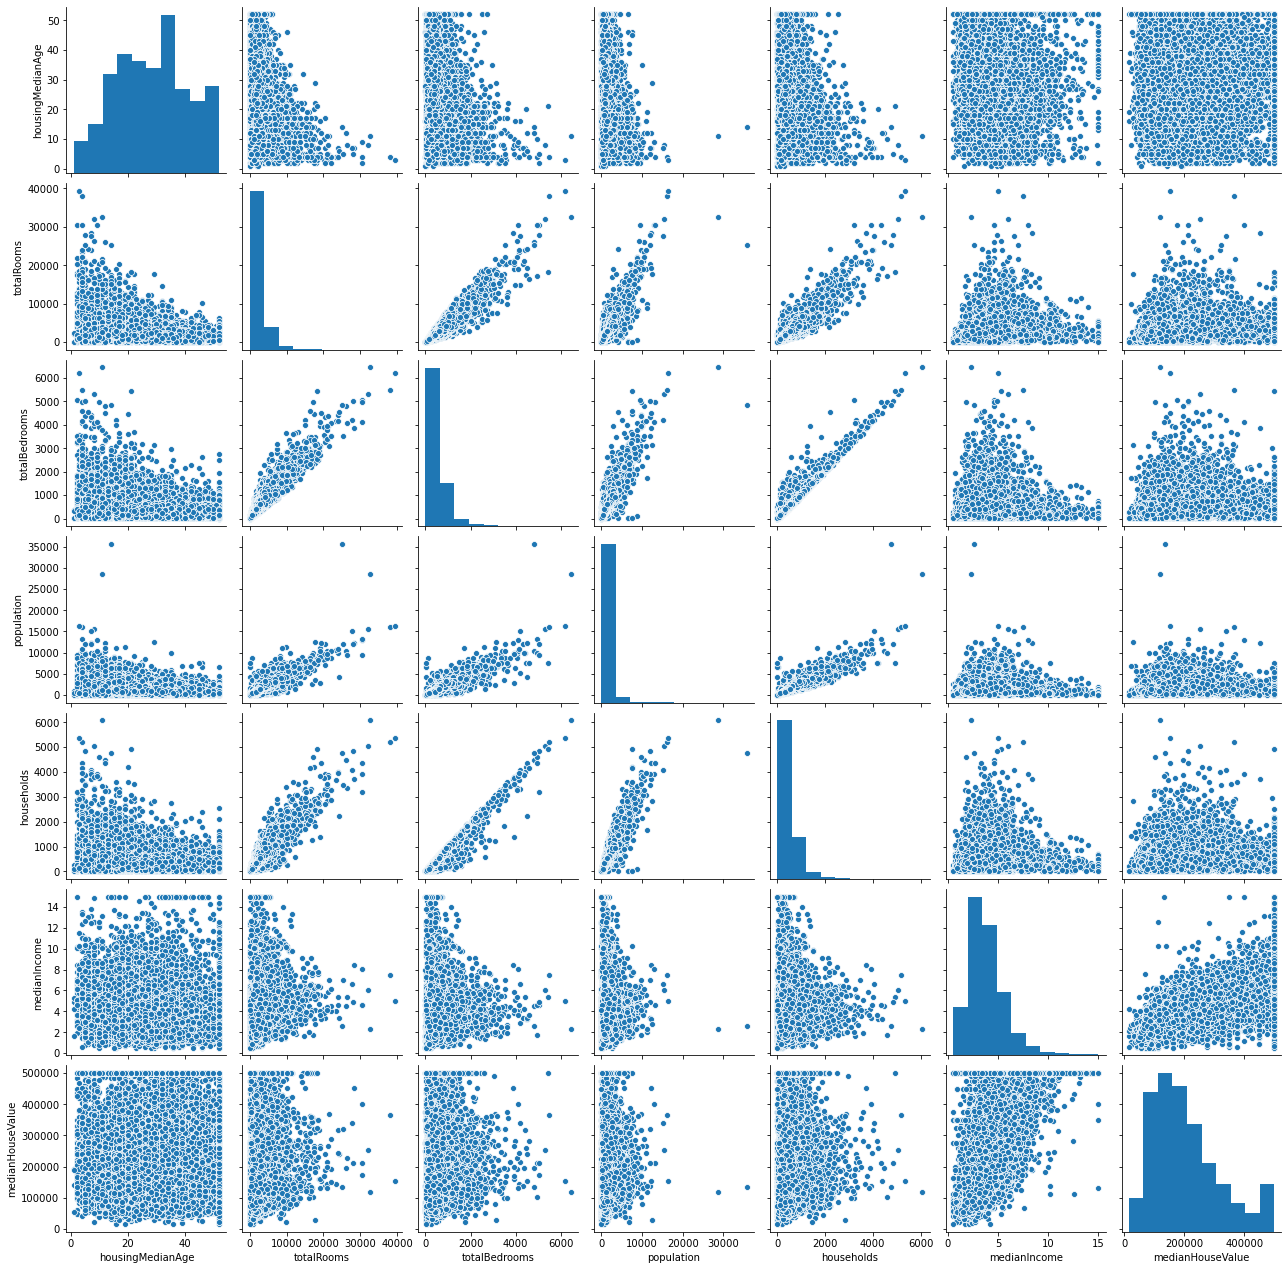

In [5]:
# visual inspection
import seaborn as sns
plot = sns.pairplot(df)

In [6]:
# correlation function
rho, pval = stats.spearmanr(df[['totalRooms']], df[['totalBedrooms']])
print('totalRooms vs', 'totalBedrooms', rho)
rho, pval = stats.spearmanr(df[['totalRooms']], df[['households']])
print('totalRooms vs', 'households', rho)
rho, pval = stats.spearmanr(df[['totalBedrooms']], df[['population']])
print('totalBedrooms vs', 'population', rho)
rho, pval = stats.spearmanr(df[['households']], df[['population']])
print('households vs', 'population', rho)

totalRooms vs totalBedrooms 0.9152452489515305
totalRooms vs households 0.9067344916774163
totalBedrooms vs population 0.8713740783965954
households vs population 0.9038719229078769


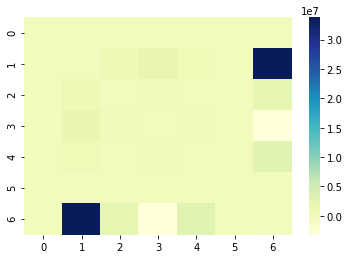

In [7]:
cov = np.cov(df.T)
cov_viz = cov.copy()
np.fill_diagonal(cov_viz,0)
ax = sns.heatmap(cov_viz,  cmap='YlGnBu')

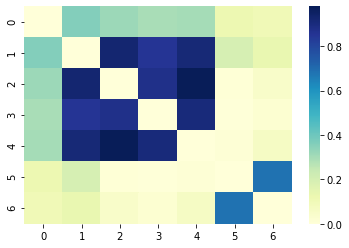

In [8]:
# standarized random variables
df = (df - np.mean(df))/np.std(df)
cov = (abs(np.cov(df.T)))
cov0 = (np.cov(df.T))
cov_viz = cov.copy()
np.fill_diagonal(cov_viz,0)
ax = sns.heatmap(cov_viz,  cmap='YlGnBu')

In [9]:
# find th eigenvalues and eigenvectors
import scipy.linalg
import decimal

vals,vecs = scipy.linalg.eig(cov0)
 
for i, v in enumerate(vals):
    # full precision
    print('var = {}'.format(i+1),decimal.Decimal(v.real))
    
# very small value  corresponds to high correlation of the variables 
# https://sam-black.medium.com/analyzing-the-eigenvalues-of-a-covariance-matrix-to-identify-multicollinearity-de488c719e1b

var = 1 3.88991002475270786220562513335607945919036865234375
var = 2 1.7005041741089830242827929396298713982105255126953125
var = 3 0.9043946177379911244287313820677809417247772216796875
var = 4 0.29030855695448476438969009905122220516204833984375
var = 5 0.14072288389757703352955786613165400922298431396484375
var = 6 0.01515204625313362231386893341777977184392511844635009765625
var = 7 0.05934686001432420976442472237977199256420135498046875


In [10]:
#gather features
features = "+".join(df.columns)
# get y and X dataframes based on this regression:
y, X = dmatrices('medianIncome ~' +features, df, return_type='dataframe')

$$ V.I.F. = 1 / (1 - R^2). $$

In [11]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF Factor,features
0,1.0,Intercept
1,1.3,housingMedianAge
2,12.1,totalRooms
3,35.9,totalBedrooms
4,6.5,population
5,34.3,households
6,2.9,medianIncome
7,2.3,medianHouseValue


In [12]:
#the total  amount of bedrooms for the households has a high variance inflation factor because they explain the same variance within this dataset.

In [13]:
# get y and X dataframes based on this regression:
y, X = dmatrices('medianHouseValue ~' +features, df, return_type='dataframe')
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

#  one of  variables having  before a high variance inflation factor must be discarded 
# before moving on to model building or risk building a model with high multicolinearity

,VIF Factor,features
0,1.0,Intercept
1,1.3,housingMedianAge
2,12.1,totalRooms
3,35.9,totalBedrooms
4,6.5,population
5,34.3,households
6,2.9,medianIncome
7,2.3,medianHouseValue


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42)
 # Instantiate the [Multiple] linear model and visualizer
model = LinearRegression().fit(X, y) # calculate the optimal values of the weights 𝑏₀ and 𝑏₁, using the existing input and output (x and y) as the arguments. 
# weights 𝑏₀ and vector 𝑏₁
print('intercept:', model.intercept_)
print('slope:', model.coef_)
r_sq = model.score(X, y)
print('coefficient of determination:', r_sq)  # the return value of 𝑅²

intercept: [-3.26364689e-16]
slope: [[ 0.00000000e+00 -1.05040972e-15 -3.62381085e-18 -1.52723364e-15
   1.00815303e-15 -4.69446249e-16 -1.11925092e-15  1.00000000e+00]]
coefficient of determination: 1.0


In [15]:
df = df[['housingMedianAge', 'totalBedrooms','population','households','medianIncome','medianHouseValue']].dropna() #subset the dataframe
print (df.columns.tolist())
df.shape

['housingMedianAge', 'totalBedrooms', 'population', 'households', 'medianIncome', 'medianHouseValue']


(20640, 6)

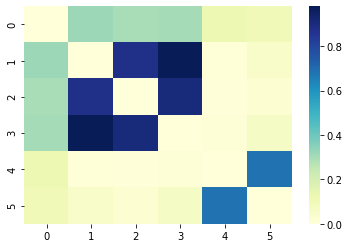

In [16]:
df = (df - np.mean(df))/np.std(df)
cov = (abs(np.cov(df.T)))
cov0 = (np.cov(df.T))
cov_viz = cov.copy()
np.fill_diagonal(cov_viz,0)
ax = sns.heatmap(cov_viz,  cmap='YlGnBu')

In [17]:
vals,vecs = scipy.linalg.eig(cov0)
 
for i, v in enumerate(vals):
    # full precision
    print('var = {}'.format(i+1),decimal.Decimal(v.real))

var = 1 2.98765898496403625728135011740960180759429931640625
var = 2 1.68826043732333364033593170461244881153106689453125
var = 3 0.9029194094756378685673325890093110501766204833984375
var = 4 0.28344385748192812979340260426397435367107391357421875
var = 5 0.1209248855766119346011322477352223359048366546630859375
var = 6 0.0170831369377336013404278247662659850902855396270751953125


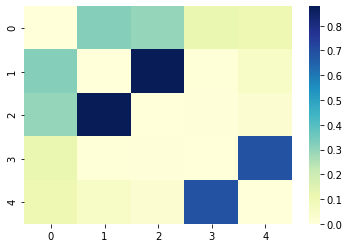

In [18]:
df = df[['housingMedianAge', 'totalBedrooms','population', 'medianIncome','medianHouseValue']].dropna() #subset the dataframe
df = (df - np.mean(df))/np.std(df)
cov = (abs(np.cov(df.T)))
cov_viz = cov.copy()
np.fill_diagonal(cov_viz,0)
ax = sns.heatmap(cov_viz,  cmap='YlGnBu')

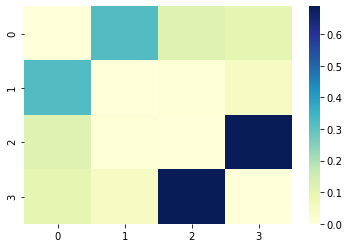

In [19]:
df = df[['housingMedianAge', 'totalBedrooms', 'medianIncome','medianHouseValue']].dropna() #subset the dataframe
df = (df - np.mean(df))/np.std(df)
cov = (abs(np.cov(df.T)))
cov0 = (np.cov(df.T))
cov_viz = cov.copy()
np.fill_diagonal(cov_viz,0)
ax = sns.heatmap(cov_viz,  cmap='YlGnBu')

In [20]:
vals,vecs = scipy.linalg.eig(cov0)
 
for i, v in enumerate(vals):
    # full precision
    print('var = {}'.format(i+1),decimal.Decimal(v.real))

var = 1 0.25785323368057377901862992075621150434017181396484375
var = 2 0.7264006743330548854231665245606563985347747802734375
var = 3 1.325447520094221953712576578254811465740203857421875
var = 4 1.69049237973161137205124759930185973644256591796875


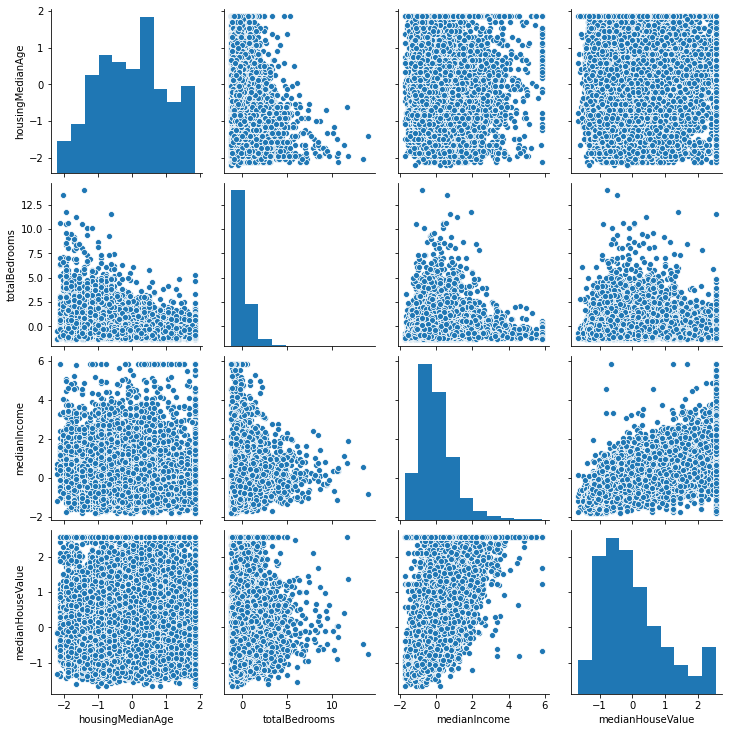

In [21]:
plot = sns.pairplot(df)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42)
 # Instantiate the [Multiple] linear model and visualizer
model = LinearRegression().fit(X, y) # calculate the optimal values of the weights 𝑏₀ and 𝑏₁, using the existing input and output (x and y) as the arguments. 
# weights 𝑏₀ and vector 𝑏₁
print('intercept:', model.intercept_)
print('slope:', model.coef_)
r_sq = model.score(X, y)
print('coefficient of determination:', r_sq)  # the return value of 𝑅²

intercept: [-3.26364689e-16]
slope: [[ 0.00000000e+00 -1.05040972e-15 -3.62381085e-18 -1.52723364e-15
   1.00815303e-15 -4.69446249e-16 -1.11925092e-15  1.00000000e+00]]
coefficient of determination: 1.0
